In [461]:
from pyntcloud import PyntCloud 
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import sys
import pdb
from pcdiff import knn_graph

%run "C:/Users/aagaa/Documents/GitHub/R-D/Code/pcdiff/grad_curvature.ipynb"

def Detect_edges(path, k_n = 20, thresh = 0.06):
    # Load the XYZ file as a DataFrame
    df = pd.read_csv(path, sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
    #df = pd.read_csv("/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/scanning_repository/horse.xyz", sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])

    # Convert DataFrame to a PyntCloud object
    pcd1 = PyntCloud(df)

    #pcd1 = PyntCloud.from_file("/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/synethsis/cube-isometric.xyz")
    #pcd1 = PyntCloud.from_file("/TetrahedronMultiple.pcd")
    #pcd1 = PyntCloud.from_file("/ArtificialPointClouds/CubeFractal2.pcd")
    output_dir = "./detected_edge/"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # define hyperparameters

    pcd_np = np.zeros((len(pcd1.points),6))

    # find neighbors
    kdtree_id = pcd1.add_structure("kdtree")
    k_neighbors = pcd1.get_neighbors(k=k_n, kdtree=kdtree_id) 

    # calculate eigenvalues
    ev = pcd1.add_scalar_field("eigen_values", k_neighbors=k_neighbors)

    x = pcd1.points['x'].values 
    y = pcd1.points['y'].values 
    z = pcd1.points['z'].values 

    e1 = pcd1.points['e3('+str(k_n+1)+')'].values
    e2 = pcd1.points['e2('+str(k_n+1)+')'].values
    e3 = pcd1.points['e1('+str(k_n+1)+')'].values

    sum_eg = np.add(np.add(e1,e2),e3)
    sigma = np.divide(e1,sum_eg)
    sigma_value = sigma

    sigma_value = (e3 - e2) / e1
    #pdb.set_trace()
    #img = ax.scatter(x, y, z, c=sigma, cmap='jet')

    # visualize the edges
    sigma = sigma>thresh

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Visualize each one of the eigenvalues
    #img = ax.scatter(x, y, z, c=e1, cmap='jet')
    #img = ax.scatter(x, y, z, c=e2, cmap='jet')
    #img = ax.scatter(x, y, z, c=e3, cmap='jet')

    # visualize the edges
    img = ax.scatter(x, y, z, c=sigma, cmap='jet')
    #img = ax.scatter(x, y, z, c=sigma, cmap=plt.hot())

    fig.colorbar(img) 
    plt.show() 

    # Save the edges and point cloud
    #thresh_min = sigma_value < thresh
    #sigma_value[thresh_min] = 0
    #thresh_max = sigma_value > thresh
    #sigma_value[thresh_max] = 255

    pcd_np[:,0] = x
    pcd_np[:,1] = y
    pcd_np[:,2] = z
    pcd_np[:,3] = sigma_value

    __, curvature_far, __ = grad_curvature(pcd_np[:,0:3],40)

    k = 20
    
    nbh = knn_graph(pcd_np[:,0:3], k)
    row, col = nbh
    curve_diffs = (curvature_far[col] - curvature_far[row]).reshape(-1,k)
    curve_diffs = np.mean(curve_diffs, axis = 1)

    diff = curvature_far

    #diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))
    sigma_value = (sigma_value - np.min(sigma_value)) / (np.max(sigma_value) - np.min(sigma_value))
    curve_inverse = np.max(np.abs(curvature_far)) - np.abs(curvature_far)
    sigma_inverse = np.max(np.abs(sigma_value)) - np.abs(sigma_value)
    sigma_mean = np.mean(np.abs(sigma_value[col]).reshape(-1,k), axis=1)
    #sigma_inverse = np.max(np.abs(sigma_mean)) - np.abs(sigma_mean)
    curve_factor = np.abs(curve_diffs) * (np.max(np.abs(curvature_far)) - np.abs(curvature_far))

    sigma_diff = np.mean(np.abs(sigma_value[col] - sigma_value[row]).reshape(-1,k), axis=1)
    sigma_ddiff = np.mean(np.abs(sigma_diff[col] - sigma_diff[row]).reshape(-1,k), axis=1)
    curve_factor = sigma_ddiff * sigma_inverse
    
#    curve_factor = np.mean(np.abs(sigma_value[col] - sigma_value[row]).reshape(-1, k) * sigma_inverse.reshape(-1,1)**4 * curve_inverse.reshape(-1,1),axis=1)

    curve_factor = (curve_factor - np.min(curve_factor)) / (np.max(curve_factor) - np.min(curve_factor))

    thresh_adjust = curve_factor * thresh * 1

    edge_np = np.delete(pcd_np, np.where(pcd_np[:,3] < thresh - thresh_adjust), axis=0) 

    edge_indicies = np.where(pcd_np[:,3] >= thresh - thresh_adjust)

    clmns = ['x','y','z','red','green','blue']
    pcd_pd = pd.DataFrame(data=pcd_np,columns=clmns)
    pcd_pd['red'] = sigma_value.astype(np.uint8)

    #pcd_points = PyntCloud(pd.DataFrame(data=pcd_np,columns=clmns))
    pcd_points = PyntCloud(pcd_pd)
    edge_points = PyntCloud(pd.DataFrame(data=edge_np,columns=clmns))

    #pcd_points.plot()
    #edge_points.plot()

    #PyntCloud.to_file(pcd_points,output_dir+'pointcloud_edges.ply')   # Save the whole point cloud by painting the edge points
    PyntCloud.to_file(edge_points,output_dir+'edges.ply')             # Save just the edge points

    np.savetxt("./detected_edge/curvature.xyz", np.hstack((pcd_np[:,0:3], sigma_value.reshape(-1, 1))), fmt="%.6f", delimiter=" ")

    return edge_indicies, curve_factor

In [348]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

C:\Users\aagaa\AppData\Local\Temp\ipykernel_17036\381488237.py:53: RuntimeWarning: divide by zero encountered in divide
  sigma_value = (e3 - e2) / e1


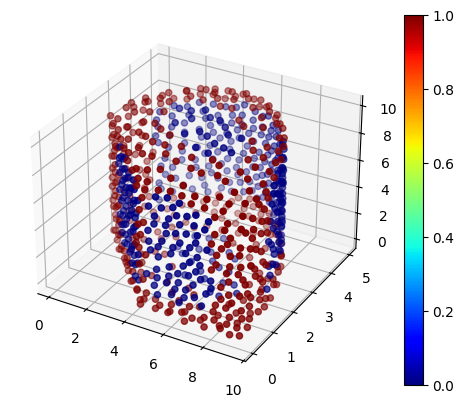

C:\Users\aagaa\AppData\Local\Temp\ipykernel_17036\381488237.py:98: RuntimeWarning: invalid value encountered in divide
  sigma_value = (sigma_value - np.min(sigma_value)) / (np.max(sigma_value) - np.min(sigma_value))


(1, 0)
(747,)


C:\Users\aagaa\AppData\Local\Temp\ipykernel_17036\381488237.py:121: RuntimeWarning: invalid value encountered in cast
  pcd_pd['red'] = sigma_value.astype(np.uint8)
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\io\ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = property_formats[str(df.dtypes[i])[0]]
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\io\ply.py:260: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = property_formats[str(df.dtypes[i])[0]]
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\io\ply.py:260: FutureWarning: Series.__getitem__ treating keys as po

In [462]:
edges, curvature = Detect_edges("C:/Users/aagaa/Documents/GitHub/R-D/Drawings/STL/test.xyz", k_n = 20, thresh = 0.008)
print(np.array(edges).shape)
print(curvature.shape)

In [542]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap

@jit
def get_eigenvalues(neighborhood):
    # Compute the covariance matrix using JAX
    cov_matrix = jnp.cov(neighborhood.T)

    # Perform PCA (eigenvalue decomposition) using JAX
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues in descending order
    sorted_indices = jnp.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    curvature = eigenvalues[2] / jnp.sum(eigenvalues)
    anisotropy = (eigenvalues[0] - eigenvalues[2]) / eigenvalues[0]
    linearity = (eigenvalues[0] - eigenvalues[1]) / eigenvalues[0]
    planarity = (eigenvalues[1] - eigenvalues[2]) / eigenvalues[0]
    sphericity = eigenvalues[2] / eigenvalues[0]
    variation = eigenvalues[0] / (eigenvalues[0] + eigenvalues[2])

    return curvature, planarity

In [600]:

Pointcloud = np.loadtxt("C:/Users/aagaa/Documents/GitHub/R-D/Drawings/STL/test.xyz")[:,0:3]

k = 50

Pointcloud_jax = jnp.array(Pointcloud)

nbh_index = knn_graph(Pointcloud, k)

row, col = nbh_index

nbh_data = Pointcloud_jax[col].reshape(-1,k,3)

curvature = jnp.zeros_like(Pointcloud[:,0])
planarity = jnp.zeros_like(Pointcloud[:,0])

curv, plan = get_eigenvalues(nbh_data[0,:,:])


for i in range(nbh_data.shape[0]):
    curv, plan = get_eigenvalues(nbh_data[i,:,:])
    curvature = curvature.at[i].set(curv)
    planarity = planarity.at[i].set(plan)
new = planarity * curvature

k=6
nbh_index = knn_graph(Pointcloud, k)
row, col = nbh_index
nbh_data = Pointcloud_jax[col].reshape(-1,k,3)
curvature = jnp.zeros_like(Pointcloud[:,0])
for i in range(nbh_data.shape[0]):
    curv, plan = get_eigenvalues(nbh_data[i,:,:])
    curvature = curvature.at[i].set(curv)

plan_thresh = 0.8
edge_thresh_low = 0.005
edge_thresh_high = 0.05

#Find indexes where planarity is high
plan_index = np.where(planarity > plan_thresh)[0]
#Create pointcloud of planary points
pc_plan = Pointcloud[plan_index,:]
#Create curvature array of planary points
plancurv_index = curvature[plan_index]
#Find indexes of highest curvatures in planary areas
pc_plan_index = np.where(plancurv_index > edge_thresh_low)[0]

#Find indexes where planarity is high
curv_index = np.where(planarity < plan_thresh)[0]
#Create pointcloud of planary points
pc_curv = Pointcloud[curv_index,:]
#Create curvature array of planary points
curvcurv_index = curvature[curv_index]
#Find indexes of highest curvatures in planary areas
pc_curv_index = np.where(curvcurv_index > edge_thresh_high)[0]

Pointcloud_plan = pc_plan[pc_plan_index,:]
Pointcloud_curv = pc_curv[pc_curv_index,:]

edges = np.vstack((Pointcloud_plan,Pointcloud_curv))

#Pointcloud_plan = np.where(planarity < plan_thresh), axis=0
#curvature_plan = np.delete(curvature, np.where(planarity < plan_thresh), axis=0)
#Pointcloud_plan = np.delete(Pointcloud_plan, np.where(curvature_plan < 0.005), axis=0

#Pointcloud_curv = np.delete(Pointcloud, np.where(planarity >= plan_thresh), axis=0)
#curvature_curv = np.delete(curvature, np.where(planarity >= plan_thresh), axis=0)
#Pointcloud_curv = np.delete(Pointcloud_plan, np.where(curvature_curv < 0.05), axis=0)

np.savetxt("./detected_edge/curvature.xyz", edges, fmt="%.6f", delimiter=" ")
#np.savetxt("./detected_edge/curvature.xyz", np.hstack((Pointcloud, np.array(curvature).reshape(-1, 1))), fmt="%.6f", delimiter=" ")
#print(Pointcloud.shape)